# COMP9444 Project Report: Building a Cart Pole game using DDQN

***




# Importing Packages

In [9]:
import torch
from collections import deque
import gym
import numpy as np
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


# Hyperparameters 


In [10]:
# Hyperparameters
max_epsilon = 1
min_epsilon = 0.005
epsilon_decay = 0.005
batch_size = 50
replay_capacity = 3000
lr = 0.001
gamma = 0.999
hid = 80
num_episodes = 2000
avg_steps = 195
continue_reward = 1
fail_reward = -400
target_update = 20
epoch = 50
seed = 20
torch.manual_seed(seed)
random.seed(seed)


# Define Agent Class
The agent follows a strategy to choose actions based on the current states, it directly interact with the game(env).

- ``get_action`` - the current policy is epsilon greedy policy, which means it would choose action either using model or randomly based on the probability of epsilon value. Besides, the epsilon value would decay exponentially (control the decay rate via ``epsilon_decay``)


In [11]:

# Agent class
class Agent():
    def __init__(self, strategy, action_dim, device) -> None:
        self.current_step = 0
        # Current stretagy is epsilon greedy stretagy
        self.strategy = strategy
        self.action_dim = action_dim
        self.device = device

    # Get actions according to current state and DQN
    def get_action(self, state, policy_net): 
        epsilon = self.strategy.get_epsilon(self.current_step)
        self.current_step += 1

        # Exploration
        if random.random() < epsilon:
            # print('explore')
            return random.randint(0, self.action_dim - 1)
        
        # Exploitation
        else: 
            # print('exploit')
            with torch.no_grad():
                return policy_net(torch.tensor(state).to(device)).argmax().item()


# Experience replay
A memory block which stroing pervious states and actions, accumulated those experience and make use of that for the action choosing. This blocks is for training the neurtal network for better descripting the environments.In such way, agent is learning both on a current state and stored previous states. 

- ``sample`` - randomly select a batch from the pervious state transitions stored for training.
- ``enough_sample`` - this enable the agent will only be trained after accumulated centain amount of experience, i.e. specified by ``batch_size``.


In [12]:

# Experience buffer
class ReplayMemory():
    def __init__(self) -> None:
        self.capacity = replay_capacity
        self.memory = deque()
        self.push_count = 0
    
    # Store experience in memory buffer
    def push(self, current_state, action, reward, next_state, done):
        self.memory.append((current_state, action, reward, next_state, done))
        
        # If the buffer is full, remove first experience
        if len(self.memory) > self.capacity:
            self.memory.popleft()
        self.push_count += 1
    
    # Get a batch of experience at random
    def sample(self):
        return random.sample(self.memory, batch_size)

    # Check is the number of experience in buffer enough for training
    def enough_sample(self):
        return len(self.memory) > batch_size

# Strategy
Considering exploration-exploitation trade-off, we use epsilon greedy strategy. It would initially have more chance to explore and then as the episode increase, it would tend to make use of the policy learned.

- ``get_epsilon`` - get the probability for choosing exploration or exploitation. The epsilon value would decay exponentially (control the decay rate via ``epsilon_decay``). The probability would starts from ``max_epsilon`` and decrease to ``min_epsilon``. 

In [13]:
# Epsilon greedy strategy
class EpsilonGreedyStrategy():
    def __init__(self) -> None:
        self.epsilon = max_epsilon

    # Decrease epsilon each time epsilon is required in order to give more and more chance to exploit
    def get_epsilon(self, current_step):
        self.epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay * current_step)
        return self.epsilon

# DQN 
Table-based state-space representation woule be less appropriate as the carpole are contineuous rather than discrete since the pole can lean to any degree.

Neural network would be used in this case to approximate the Q function.

Here we also test different layers, which include increase hidden unit number, layer amount and **dense layer**.

In [14]:

# Deep Q network
class DQN(torch.nn.Module): 
    def __init__(self, state_dim, action_dim) -> None:
        # Quite simple fully connected network copied from Assignment 1
        super(DQN, self).__init__()
        self.in_to_hid1 = torch.nn.Linear(state_dim, hid)
        self.hid1_to_hid2 = torch.nn.Linear(hid, hid)
        self.hid2_to_out = torch.nn.Linear(hid, action_dim)

    # Forward mathod
    # Input: Current state
    # Output: Q value for each action
    def forward(self, input):
        hid1_sum = self.in_to_hid1(input)
        self.hid1 = torch.relu(hid1_sum)
        hid2_sum = self.hid1_to_hid2(self.hid1)
        self.hid2 = torch.relu(hid2_sum)
        output_sum = self.hid2_to_out(self.hid2)
        output = output_sum
        return output

# Compute Q-value
As we use nn to descript the environment, we would need to use the tensor values here to compute Q value.
- ``get_current`` - get the **q value** for current state from the neurat network.
- ``get_next`` - get the **optimal q value** from the target network (here is DDQN method as DQN would tend to overoptimistic) 


In [15]:

# Functions that give Q values
class Q_values():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Get Q value for current states
    @staticmethod
    def get_current(policy_net, current_state_batch, action_batch):
        return policy_net(current_state_batch).gather(dim=1, index=action_batch.unsqueeze(-1)).flatten()

    # Get Q value for next states
    # Known as target Q value and Q star value
    @staticmethod
    def get_next(target_net, next_state_batch, done_batch):
        index = 0
        for done in done_batch:
            
            # If this is end state, Q star value should be 0
            if done: 
                next_state_batch[index] = 0
            index += 1

        Q_star = target_net(next_state_batch).max(dim=1)[0].detach()
        return Q_star



# Training loop 
### Construct a target network 
DQN services as a great function approximator and provide Q values. However, DQN would frequently update the weights at each timestep, which is likely to form a function that choose over-estimated value. DDQN was introduced to solve this.

DDQN tried to separate the action choosing and action evaluating. It would have two network, which is **policy network** and **target network**.It woul training and updating in policy network for a certain time before it actually update the target network. Via giving the target network more time to watch what policy learned and then update it self, it would constructe a stable neural network. 


C:\Users\22339\AppData\Roaming\Python\Python39\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(
C:\Users\22339\AppData\Roaming\Python\Python39\site-packages\gym\core.py:200: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


episode 50, avg t: 14.46, avg reward: -385.35
episode 100, avg t: 113.62, avg reward: -191.23
episode 150, avg t: 186.26, avg reward: -41.29
episode 200, avg t: 272.00, avg reward: 345.61
episode 250, avg t: 368.80, avg reward: 774.76
episode 300, avg t: 447.22, avg reward: 1254.65
episode 350, avg t: 240.20, avg reward: 243.29
episode 400, avg t: 267.34, avg reward: 348.25
episode 450, avg t: 143.88, avg reward: -135.87
episode 500, avg t: 259.98, avg reward: 242.32
episode 550, avg t: 236.22, avg reward: 117.50
episode 600, avg t: 251.80, avg reward: 218.73
episode 650, avg t: 316.78, avg reward: 646.17
episode 700, avg t: 357.96, avg reward: 827.83
episode 750, avg t: 317.72, avg reward: 558.60
episode 800, avg t: 498.50, avg reward: 1706.25
episode 850, avg t: 294.62, avg reward: 326.22
episode 900, avg t: 276.78, avg reward: 429.30
episode 950, avg t: 376.62, avg reward: 949.11
episode 1000, avg t: 422.88, avg reward: 1238.53
episode 1050, avg t: 342.86, avg reward: 706.93
episode

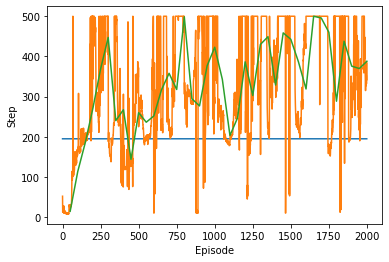

In [16]:

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    env = gym.make('CartPole-v1')
    env.seed(seed)
    action_dim = env.action_space.n
    state_dim = env.observation_space.shape[0]
    strategy = EpsilonGreedyStrategy()
    agent = Agent(strategy, action_dim, device)
    memory = ReplayMemory()

    # policy net is used for training
    # target net is used for calculating Q next value to evaluate Q value gotten from policy net
    policy_net = DQN(state_dim, action_dim).to(device)
    target_net = DQN(state_dim, action_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optimizer = torch.optim.Adam(params=policy_net.parameters(), lr=lr)

    # total reward is for testing purpose
    round_batch = []
    total_round = []
    avg_reward = []
    avg_round = []
    num_success = 0
    for episode in range(1, num_episodes + 1):
        current_state = env.reset(seed=seed)
        round = 0
        success = False
        acc_reward = 0
        done = False
        c_reward = continue_reward

        # Try to play game, if done, the loop ends
        while not done:
            action = agent.get_action(current_state, policy_net)
            next_state, reward, done, _ = env.step(action)
            if done and round < 499:
                reward = fail_reward
            else:
                reward = c_reward
                c_reward += 0.01
            acc_reward += reward
            memory.push(current_state, action, reward, next_state, done)
            current_state = next_state

            # Training the model
            if memory.enough_sample():
                minibatch = memory.sample()

                # Extract components of experiences into different tensors
                current_state_batch = torch.tensor(np.array([data[0] for data in minibatch])).to(device)
                action_batch = torch.tensor([data[1] for data in minibatch]).to(device)
                reward_batch = torch.tensor([data[2] for data in minibatch]).to(device)
                next_state_batch = torch.tensor(np.array([data[3] for data in minibatch])).to(device)
                done_batch = torch.tensor([data[4] for data in minibatch]).to(device)

                current_Q_value_batch = Q_values.get_current(policy_net, current_state_batch, action_batch)
                next_Q_value_batch = Q_values.get_next(target_net, next_state_batch, done_batch)
                Q_star_batch = reward_batch + gamma * next_Q_value_batch
                loss = F.mse_loss(current_Q_value_batch, Q_star_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            round += 1
            if done:
                round_batch.append(round)
                total_round.append(round)
                avg_reward.append(acc_reward)
                break

        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # For testing purpose
        if episode > 0 and episode % epoch == 0:
            print("episode {}, avg t: {:.2f}, avg reward: {:.2f}".format(episode, np.mean(round_batch), np.mean(avg_reward)))
            avg_round.append(np.mean(round_batch))
            round_batch = []
            avg_reward = []
    env.close()

    for rounds in avg_round:
        if rounds >= avg_steps:
            num_success += 1
    print('Numbers of success: {} Successful rate: {:.2f} Average steps: {}'.format(num_success, (num_success / (num_episodes / epoch)), np.mean(avg_round)))
    plt.plot(range(num_episodes), [avg_steps] * num_episodes)
    plt.plot(range(num_episodes), total_round)
    plt.plot(np.linspace(epoch, num_episodes, num= int(num_episodes / epoch)), avg_round)
    plt.xlabel('Episode')
    plt.ylabel('Step')
    plt.show()